In [1]:
import sys
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import sklearn 
import lightgbm
import xgboost
import pymongo
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import re
import glob 
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta, timezone
import scipy
from scipy import stats,interpolate
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from pymongo import MongoClient
import pytz
from zoneinfo import ZoneInfo
import random
import tensorflow 
import tensorflow as tf
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import warnings 
warnings.filterwarnings(action='ignore')

#### 1.) 데이터 수집
- MongoDB 사출데이터 수집방식 변경 (기존 전체 개별 1 Shot단위 --> N Cavity = 1Shot 형성 단위)
- PLC데이터 설비 이상 --> 추가 활용 불가 발생
- 사출데이터 라벨링 적합성 문제 & 불량발생 정보 불분명 발생 --> 지도학습 기반 추가학습 불가
- 2025-01-01부터 코드작업 기준 날짜까지의 데이터 재수집 --> 기존 [13,14,15,16,17,18]호기 중 일부 사출기 데이터 수집 불가 

In [3]:
def load_data(machine_number):

    #### 1.) MongoDB 데이터 재수집 [ DB & Collection 변경 ]
    from pymongo import MongoClient
    from datetime import datetime,timedelta
    pd.set_option('display.max_columns', None)
    server_address = "private_server_address"
    client_update = MongoClient("mongodb://private_compnay_client@{0}/admin".format(server_address))
    db = client_update["privateDB"]
    col2 = db['injectionmoldData']
    from_date = datetime(2025,1,1,0,0,0) 
    utc_now = datetime.now(timezone.utc)
    kst_now = utc_now.astimezone(ZoneInfo("Asia/Seoul"))
    to_date = datetime(kst_now.year, kst_now.month, kst_now.day,kst_now.hour,kst_now.minute,kst_now.second)
    df_injection = pd.DataFrame(list(col2.find({"PlantNo": f"A01-0{str(machine_number)}",
            "$and":[{"timeStamp":{"$gte":from_date}},{"timeStamp":{"$lte":to_date}}]})))
    if len(df_injection)==0:
        print('No Existing Data')
    else:
        pass

    #### 2.) Data Type변경 & 수집시간 KST = UTC + 9H 조정 
    df_injection[['Value1','Value2','Value3','Value4','Aqty','ItemVolume','MoldVolume']] = df_injection[['Value1','Value2','Value3','Value4','Aqty','ItemVolume','MoldVolume']].astype(float)
    df_injection = df_injection.replace(r'^\s*$', np.nan, regex=True)
    df_injection['timeStamp'] = df_injection['timeStamp'] + timedelta(hours=9)
    df_injection['CreateDate'] = df_injection['CreateDate'] + timedelta(hours=9)

    #### 3.) 새로운 항목인 불량유형(Labeling) 결측 점검 --> Nan/ Blank 정보 시 정상으로 가정 
    df_defect_defined = df_injection[df_injection['LabelingDefectTypes'].notna()]
    if (df_defect_defined['LabelingResult'].isna()).any() == True:
        df_defect_defined['LabelingResult'].fillna('0',inplace=True)
    else:
        pass
    df_defect_defined['PassOrFail'].fillna('0',inplace=True)
    df_defect_defined['PassOrFail'].replace({'0':'1'},inplace=True)
    df_defect_defined['LabelingResult'].replace({'0':'1'},inplace=True)
    df_defect_defined['PassOrFail'] = 1
    df_defect_defined['LabelingResult'] = 1
    
    df_defect_undefined = df_injection[df_injection['LabelingDefectTypes'].isna()]
    df_defect_undefined['PassOrFail'].fillna('1',inplace=True)
    df_defect_undefined['LabelingResult'].fillna('1',inplace=True)
    df_defect_undefined['PassOrFail'].replace({'1':'0'},inplace=True)
    df_defect_undefined['LabelingResult'].replace({'1':'0'},inplace=True)
    df_defect_undefined['LabelingDefectTypes'].fillna('No Defect',inplace=True)
    df_defect_undefined['PassOrFail'] = 0
    df_defect_undefined['LabelingResult'] = 0

    #### 4.) 불량유형 정보 확인 완료 
    df_concat = pd.concat([df_defect_defined,df_defect_undefined],axis=0).sort_values(by='timeStamp').reset_index(drop=True)
    df_concat[['PassOrFail','LabelingResult']] = df_concat[['PassOrFail','LabelingResult']].astype(int)
    #df_concat.dropna(axis=0,inplace=True)
    df_concat.dropna(axis=1,inplace=True)
    
    #### 5.) 불필요 Column 제거 
    cols = df_concat.columns.tolist()
    cols.remove('_id')
    cols.remove('IdentificationGroup')
    cols.remove('CavityNo')
    cols.remove('UniqeNumAndCavity')
    cols.remove('Ymdate')
    cols.remove('PassOrFail')
    cols.remove('LabelingResult')
    cols.remove('LabelingDefectTypes')
    cols.remove('Value1')
    cols.remove('Value2')
    cols.remove('Value3')
    cols.remove('Value4')

    #### 6.) N Cavity = 1 Shot 형태 데이터로 결합 
    df_info = df_concat.groupby('timeStamp')[cols].agg(pd.Series.mode)
    df_label1 = df_concat.groupby('timeStamp')[['Value1','Value2','Value3','Value4']].mean()
    df_label2 = df_concat.groupby('timeStamp')[['PassOrFail','LabelingResult','LabelingDefectTypes']].max()
    df_cavity = df_concat.drop(['CreateDate'],axis=1)
    df_shot = pd.concat([df_info,df_label1,df_label2],axis=1).drop(['CreateDate'],axis=1).reset_index(drop=True)
    df_shot[['Value1','Value2','Value3','Value4']] = df_shot[['Value1','Value2','Value3','Value4']].astype(float)

    return df_cavity, df_shot

#### 2.) Simple AutoEncoder 학습
- 이전 사출데이터와 달리 불량정보 불분명으로 극도로 적은 불량(Ex. 10,000개당 10개 미만 발생) or Non 불량데이터 수집
-  현재 Cavity & 불량유형 명시 안된 정상으로 간주된 데이터로 비지도학습모델 대체 구축

In [4]:
def build_autoencoder(X):
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    outer = 128
    inner = 64
    latent_vector = 8
    dropout_ratio = 0.15
    function = 'relu' # 'relu','tanh'
    input_layer = Input(shape = (X.shape[1],))
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    encoded = Dense(latent_vector, activation = function)(encoded) 
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mae')
    return autoencoder

def train_autoencoder(model,df):
    name = 'models/'+str(df['PlantNo'].unique()[0])+'_autoencoder_best_weight.h5'
    batch = 100
    epoch = 1000
    val = 0.2
    checkpointer = ModelCheckpoint(filepath=name,verbose=1,save_best_only=True)
    tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
    earlystopping = EarlyStopping(patience=5,verbose=0)
    history = model.fit(X,X,batch_size = batch,epochs = epoch,validation_split=val,callbacks=[checkpointer,tensorboard,earlystopping])
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()
    return history 

def reconstruction_loss(model,x_train):
    x_train_pred  = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    threshold = np.percentile(train_mae_loss,99.9)
    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.axvline(threshold,linestyle='dashdot',color='red')
    plt.hist(train_mae_loss, bins=50,color='blue',density=True,label='Train')
    plt.legend()
    plt.show()
    threshold_train = threshold 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", [threshold_train,np.percentile(train_mae_loss,99.99)])
    print('\n')
    train_mae_df = pd.DataFrame(train_mae_loss.describe()).rename(columns={0:'Train_MAE'})
    return train_mae_loss, threshold_train

def anomaly_threshold(X,threshold,train_mae_loss,df):
    test_score_df = pd.DataFrame(X[:])
    test_score_df['mae_loss'] = train_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['mae_loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    test_check = pd.concat([X.reset_index(drop=True),test_score_df['mae_loss'],test_score_df['threshold'],test_score_df['anomaly'],test_score_df['score']],axis=1)
    test_error = pd.DataFrame({'Reconstruction_error': test_score_df['mae_loss'],'Anomaly': test_score_df['score']})
    test_df = test_check[['mae_loss','threshold','anomaly','score']]
    groups = test_error.groupby('Anomaly')
    fig, ax = plt.subplots(figsize = (20,8))
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='+', ms=10, linestyle='',label= "Normal" if name == 0 else "Anomaly",color='blue' if name == 0 else "red")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="orange", zorder=150, label='Fault Threshold')
    ax.legend()
    plt.title('Machine='+str(df['PlantNo'].unique()[0])+' Reconstruction Error',fontsize=13)
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data Index")
    plt.grid()
    plt.show();
    df_labeled = pd.concat([df,test_df],axis=1)
    return df_labeled

#### 3.) Ex. 사출기 18호 학습 
- 학습모델 & Reconstruction Loss 계산 위한 입력값들의 npy 저장 

(196727, 22) (102359, 17)
0        2025-01-02 08:31:20.587
1        2025-01-02 08:32:11.102
2        2025-01-02 08:33:01.557
3        2025-01-02 08:33:52.094
4        2025-01-02 08:34:43.605
                   ...          
102354   2025-03-20 18:39:40.041
102355   2025-03-20 18:40:50.006
102356   2025-03-20 18:42:04.355
102357   2025-03-20 18:43:22.132
102358   2025-03-20 18:44:35.517
Name: timeStamp, Length: 102359, dtype: datetime64[ns]


Epoch 1/1000
807/818 [============================>.] - ETA: 0s - loss: 0.0542   
Epoch 00001: val_loss improved from inf to 0.01742, saving model to models\A01-018_autoencoder_best_weight.h5
818/818 [==============================] - 5s 5ms/step - loss: 0.0536 - val_loss: 0.0174
Epoch 2/1000
806/818 [============================>.] - ETA: 0s - loss: 0.0099
Epoch 00002: val_loss improved from 0.01742 to 0.01632, saving model to models\A01-018_autoencoder_best_weight.h5
818/818 [==============================] - 4s 4ms/step - loss: 0.0099 - val_loss

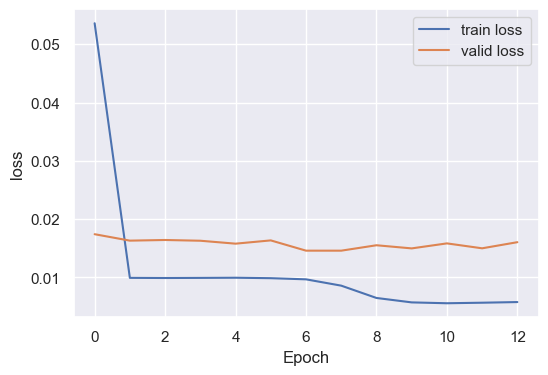

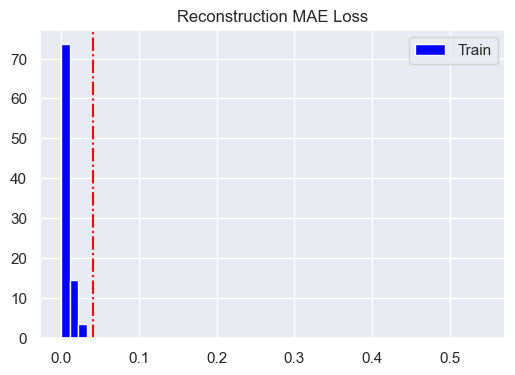



Train (Normal Only) Reconstruction error threshold: [0.041249718967865424, 0.23223948288500298]




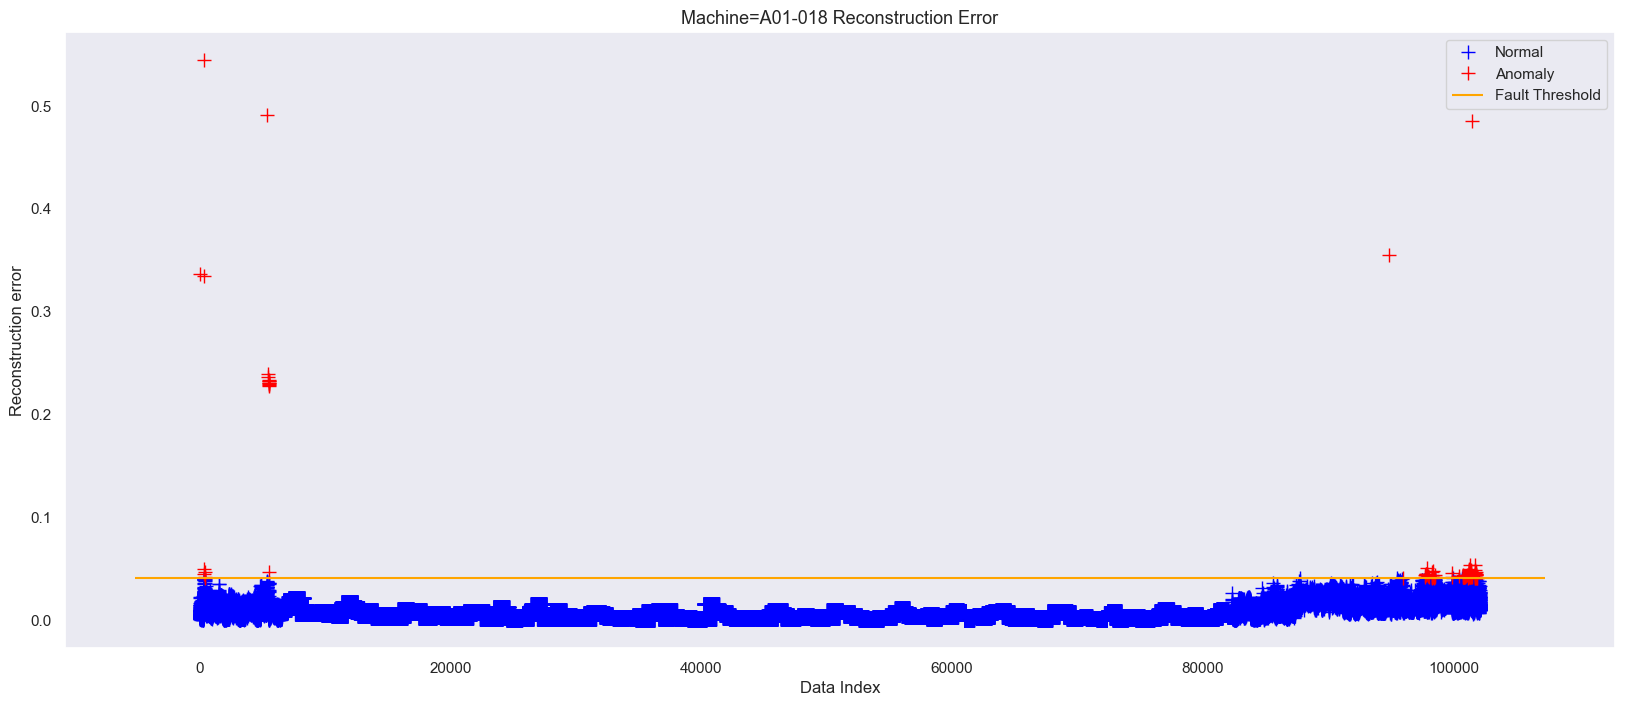

score
0    102058
1       103
Name: count, dtype: int64


In [5]:
#### 1.) 사출기 18호 데이터 수집 
machine_number = 18 # 13,14,16,17,18
df_cavity, df_shot = load_data(machine_number)
print(df_cavity.shape , df_shot.shape)
print(df_shot.timeStamp)
print('\n')

#### 2.) N Cavity = 1Shot 데이터 형성 & 정상으로 간주된 데이터들의 수치형 입력값 정의 
df = df_shot[df_shot['PassOrFail']==0].reset_index(drop=True)
df_inputs = df[['Value1','Value2','Value3','Value4']]

#### 3.) MinMax Scaler로 입력데이터 전처리 
X_train = df_inputs
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns =X_train.columns)
X = X_train_scaled

#### 4.) AutoEncoder 학습모델 구축 & 결과 시각화 및 모델/Trained_npy 저장 
autoencoder = build_autoencoder(X)
history  = train_autoencoder(autoencoder,df)
train_mae_loss, threshold_train = reconstruction_loss(autoencoder,X_train_scaled) 
threshold = threshold_train
df_labeled = anomaly_threshold(X,threshold,train_mae_loss,df)
print(df_labeled['score'].value_counts())

train_npy = np.array(X_train)
np.save('train_npy/Train_Machine18.npy',train_npy)